# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 51kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

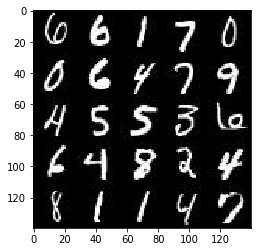

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

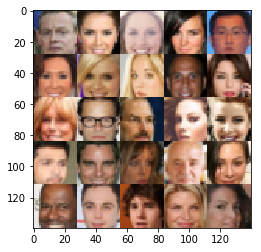

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, 
                                 shape=(None, image_width, image_height, image_channels), 
                                 name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, 
                              shape=(None, z_dim), 
                              name='inputs_z')
    
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2 # Leaky ReLu hyperparameter
    with tf.variable_scope('discriminator', reuse = reuse):
        # images shape: (-1, 28, 28, 3)
        
        # convolutional layer #1
        # output shape: (-1, 14, 14, 64)
        # no batch normalization for the first layer
        x = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x) # Leaky ReLu
        
        # convolutional layer #2
        # output shape: (-1, 14, 14, 128)
        # batch normalization
        x1 = tf.layers.conv2d(x, filters=128, kernel_size=5, padding='same')
        x1 = tf.layers.batch_normalization(x1,training=True) 
        x1 = tf.maximum(alpha * x1, x1) # Leaky ReLu
        
        # convolutional layer #3
        # output shape: (-1, 7, 7, 256)
        # batch normalization
        x2 = tf.layers.conv2d(x1, filters=256, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2,training=True) 
        x2 = tf.maximum(alpha * x2, x2) # Leaky ReLu
        
        # reshape
        # output shape: (-1,7*7*256)
        x3_reshape = tf.reshape(x2,shape=[-1,7*7*256])
        
        # output layer
        # output shape: (-1,1)
        logits = tf.layers.dense(x3_reshape, units=1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2 # Leaky ReLu hyperparameter
    with tf.variable_scope('generator', reuse = not is_train):
    
        # output shape should be 28x28x3 
        
        # dense layer + reshape 
        # output shape: (-1,7,7,256)
        x = tf.layers.dense(z, units=7*7*256, activation=None)
        x = tf.reshape(x, shape=[-1,7,7,256])
        x = tf.layers.batch_normalization(x,training = is_train) 
        x = tf.maximum(alpha * x, x) # Leaky ReLu
        
        # transpose convolution layer #1
        # output shape: (-1,14,14,128)
        x1 = tf.layers.conv2d_transpose(x,filters=128,kernel_size=5,strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1,training = is_train)
        x1 = tf.maximum(alpha * x1, x1) # Leaky ReLu
        
        # transpose convolution layer #2
        # output shape: (-1,14,14,64)
        x2 = tf.layers.conv2d_transpose(x1,filters=64,kernel_size=5, padding='same')
        x2 = tf.layers.batch_normalization(x2,training = is_train)
        x2 = tf.maximum(alpha * x2, x2) # Leaky ReLu
        
        # transpose convolution layer #3
        # output shape, (-1,28,28,output_dim)
        logits = tf.layers.conv2d_transpose(x2,filters=out_channel_dim,kernel_size=5,strides=2, padding='same')
        out = tf.tanh(logits)

        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, 
                                                labels=0.9*tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_channels = 1
    if data_image_mode == 'RGB':
        image_channels = 3
        
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(1, z_dim))
    
    it = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                it+=1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images*2, inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images*2, lr: learning_rate})
                
                if it % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if it % 100 == 0:
                    show_generator_output(sess, 1, inputs_z, image_channels, data_image_mode)
         
        print('Done, showing samples')
        show_generator_output(sess, 9, inputs_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.3058... Generator Loss: 0.1125
Epoch 1/2... Discriminator Loss: 4.8286... Generator Loss: 8.4308
Epoch 1/2... Discriminator Loss: 1.6008... Generator Loss: 2.5103
Epoch 1/2... Discriminator Loss: 2.3964... Generator Loss: 3.8398
Epoch 1/2... Discriminator Loss: 1.4631... Generator Loss: 1.4479
Epoch 1/2... Discriminator Loss: 1.1591... Generator Loss: 0.8218
Epoch 1/2... Discriminator Loss: 1.4772... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 1.0295... Generator Loss: 1.3463
Epoch 1/2... Discriminator Loss: 1.5931... Generator Loss: 0.8718
Epoch 1/2... Discriminator Loss: 1.4797... Generator Loss: 0.9478


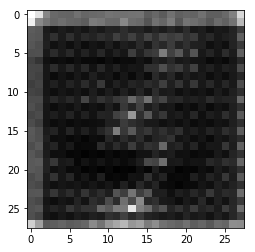

Epoch 1/2... Discriminator Loss: 1.4774... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 1.7090... Generator Loss: 0.4149
Epoch 1/2... Discriminator Loss: 2.0952... Generator Loss: 0.2776
Epoch 1/2... Discriminator Loss: 1.4168... Generator Loss: 1.2440
Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 1.1050
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.8182
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.8929
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 1.2103
Epoch 1/2... Discriminator Loss: 1.6702... Generator Loss: 2.3678
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 1.2564


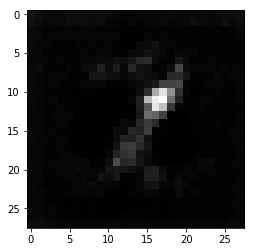

Epoch 1/2... Discriminator Loss: 1.6403... Generator Loss: 2.7351
Epoch 1/2... Discriminator Loss: 1.8512... Generator Loss: 3.0105
Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 1.3216
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 0.5117
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.6844
Epoch 1/2... Discriminator Loss: 1.9438... Generator Loss: 2.5369
Epoch 1/2... Discriminator Loss: 2.7299... Generator Loss: 4.0267
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 1.7336
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 1.5246
Epoch 1/2... Discriminator Loss: 1.0377... Generator Loss: 1.2380


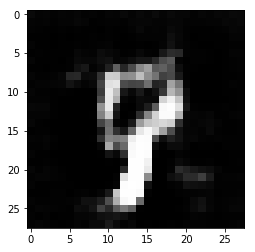

Epoch 1/2... Discriminator Loss: 1.2381... Generator Loss: 1.8172
Epoch 1/2... Discriminator Loss: 1.3012... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 0.9832... Generator Loss: 1.2626
Epoch 1/2... Discriminator Loss: 2.3865... Generator Loss: 4.2937
Epoch 1/2... Discriminator Loss: 1.2285... Generator Loss: 1.2475
Epoch 1/2... Discriminator Loss: 1.5162... Generator Loss: 2.4186
Epoch 1/2... Discriminator Loss: 2.8191... Generator Loss: 4.1539
Epoch 1/2... Discriminator Loss: 1.6245... Generator Loss: 0.5407
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 1.9357
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 1.0876


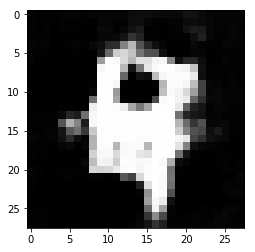

Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 1.5824
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 1.7554
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 0.9598
Epoch 1/2... Discriminator Loss: 2.4910... Generator Loss: 2.5834
Epoch 1/2... Discriminator Loss: 1.1183... Generator Loss: 0.8799
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 2.7637... Generator Loss: 0.1682
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 1.3211
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 1.0548
Epoch 1/2... Discriminator Loss: 1.4748... Generator Loss: 1.6070


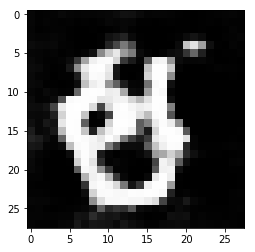

Epoch 1/2... Discriminator Loss: 1.0172... Generator Loss: 1.3675
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 1.0981
Epoch 1/2... Discriminator Loss: 1.6705... Generator Loss: 2.3781
Epoch 1/2... Discriminator Loss: 1.7051... Generator Loss: 0.5174
Epoch 1/2... Discriminator Loss: 1.1044... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 1.0387
Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 2.6803
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 0.9119
Epoch 1/2... Discriminator Loss: 1.1305... Generator Loss: 1.6737
Epoch 1/2... Discriminator Loss: 0.9937... Generator Loss: 1.3336


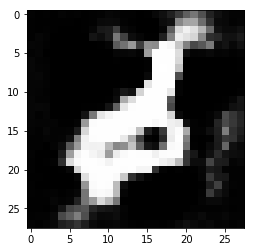

Epoch 1/2... Discriminator Loss: 3.0249... Generator Loss: 0.0932
Epoch 1/2... Discriminator Loss: 1.5821... Generator Loss: 0.4832
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 1.7585
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 1.1213
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 1.7141
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 1.9843
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 1.2420
Epoch 1/2... Discriminator Loss: 2.7300... Generator Loss: 4.1493
Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 0.9429


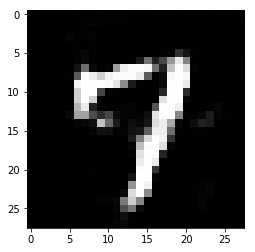

Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 1.4783
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 1.0846
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 1.1255
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.7821
Epoch 1/2... Discriminator Loss: 1.2557... Generator Loss: 0.7022
Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 0.9826
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 1.7670
Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 3.1036
Epoch 1/2... Discriminator Loss: 1.5894... Generator Loss: 2.3200
Epoch 1/2... Discriminator Loss: 1.0585... Generator Loss: 1.0757


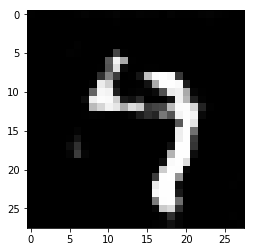

Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 1.6177
Epoch 1/2... Discriminator Loss: 0.9034... Generator Loss: 1.2345
Epoch 1/2... Discriminator Loss: 1.2198... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 1.8193... Generator Loss: 0.3041
Epoch 1/2... Discriminator Loss: 1.1959... Generator Loss: 0.7718
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 1.4597
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 1.2598
Epoch 1/2... Discriminator Loss: 1.0016... Generator Loss: 1.3178
Epoch 1/2... Discriminator Loss: 1.2456... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 1.2758... Generator Loss: 0.8657


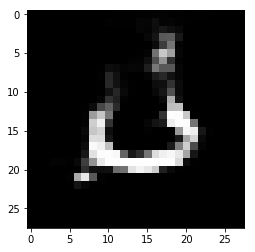

Epoch 1/2... Discriminator Loss: 1.6289... Generator Loss: 0.4076
Epoch 1/2... Discriminator Loss: 0.9877... Generator Loss: 1.0510
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.5123
Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 1.2333
Epoch 1/2... Discriminator Loss: 1.0928... Generator Loss: 0.9849
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 1.0321
Epoch 1/2... Discriminator Loss: 0.6252... Generator Loss: 1.9751
Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 1.8541
Epoch 1/2... Discriminator Loss: 1.6506... Generator Loss: 0.4214
Epoch 1/2... Discriminator Loss: 1.6477... Generator Loss: 0.3994


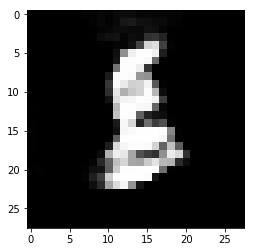

Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 1.7977
Epoch 1/2... Discriminator Loss: 1.6616... Generator Loss: 3.2246
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 1.3648
Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 1.0072
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 1.2506
Epoch 1/2... Discriminator Loss: 1.4606... Generator Loss: 2.4457
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.0155
Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 1.0963


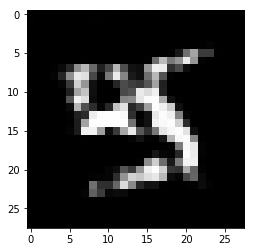

Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 0.8407
Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 1.5002
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 3.2198
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.8126
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 1.6333
Epoch 1/2... Discriminator Loss: 1.5945... Generator Loss: 1.3635
Epoch 1/2... Discriminator Loss: 1.3489... Generator Loss: 1.7576
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 1.4613
Epoch 1/2... Discriminator Loss: 1.4584... Generator Loss: 2.1834
Epoch 1/2... Discriminator Loss: 1.0389... Generator Loss: 1.0300


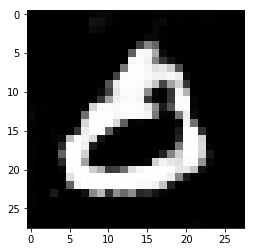

Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 2.0930... Generator Loss: 2.8236
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.6183
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.3621
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 1.4968
Epoch 1/2... Discriminator Loss: 1.6460... Generator Loss: 0.6361
Epoch 1/2... Discriminator Loss: 1.2375... Generator Loss: 0.9743
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 0.9889
Epoch 1/2... Discriminator Loss: 1.9504... Generator Loss: 0.3174
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 1.1127


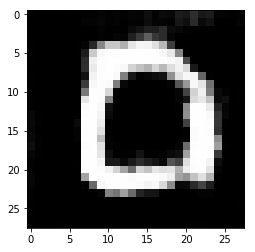

Epoch 1/2... Discriminator Loss: 0.9316... Generator Loss: 1.1680
Epoch 1/2... Discriminator Loss: 1.0803... Generator Loss: 1.3033
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 0.7452
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 1.3891
Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 1.3073
Epoch 1/2... Discriminator Loss: 1.4609... Generator Loss: 1.8894
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 1.4481
Epoch 1/2... Discriminator Loss: 1.6337... Generator Loss: 2.4352
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.8749


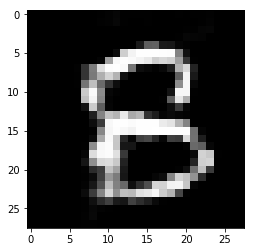

Epoch 1/2... Discriminator Loss: 1.1965... Generator Loss: 0.9123
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 1.7240
Epoch 1/2... Discriminator Loss: 1.1585... Generator Loss: 0.9164
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 1.6181
Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 0.9964
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.8125
Epoch 1/2... Discriminator Loss: 1.6695... Generator Loss: 0.4770
Epoch 1/2... Discriminator Loss: 1.4351... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 0.8779
Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 1.3884


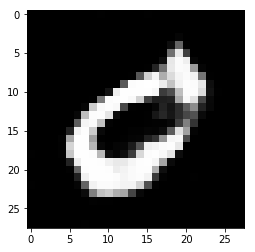

Epoch 1/2... Discriminator Loss: 1.3439... Generator Loss: 0.6130
Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 1.8450
Epoch 1/2... Discriminator Loss: 0.9893... Generator Loss: 1.0757
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.8572
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 2.0178
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 1.7705
Epoch 1/2... Discriminator Loss: 1.3951... Generator Loss: 2.0711
Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 1.1761
Epoch 1/2... Discriminator Loss: 1.4042... Generator Loss: 1.1134


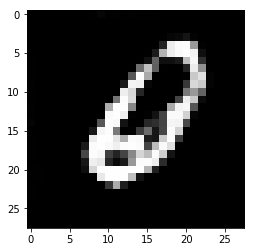

Epoch 1/2... Discriminator Loss: 1.5772... Generator Loss: 0.5296
Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 1.4075
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 1.4879
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 2.2636
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 1.4191
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 1.4946
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 1.0823
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 1.2823


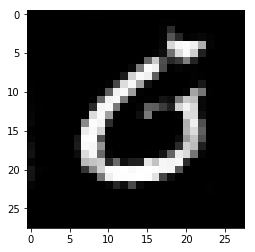

Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 1.9625
Epoch 1/2... Discriminator Loss: 0.8514... Generator Loss: 1.2314
Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 1.5373
Epoch 1/2... Discriminator Loss: 0.7976... Generator Loss: 1.6935
Epoch 1/2... Discriminator Loss: 1.2773... Generator Loss: 0.7140
Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 1.9379
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.6857... Generator Loss: 3.1711
Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 2.7387
Epoch 1/2... Discriminator Loss: 1.0815... Generator Loss: 0.7945


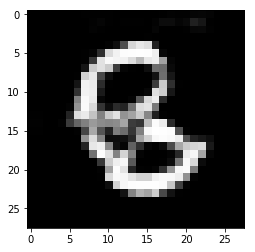

Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 1.5218
Epoch 1/2... Discriminator Loss: 1.1407... Generator Loss: 1.3677
Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.8028
Epoch 1/2... Discriminator Loss: 1.5793... Generator Loss: 1.3456
Epoch 1/2... Discriminator Loss: 1.6572... Generator Loss: 1.7588
Epoch 1/2... Discriminator Loss: 1.6100... Generator Loss: 0.9348
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.7690
Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 1.2340
Epoch 2/2... Discriminator Loss: 1.5973... Generator Loss: 0.5415
Epoch 2/2... Discriminator Loss: 1.5341... Generator Loss: 0.4700


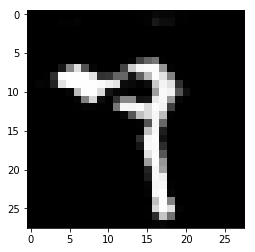

Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 1.1971
Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 0.8812
Epoch 2/2... Discriminator Loss: 1.5288... Generator Loss: 0.4757
Epoch 2/2... Discriminator Loss: 1.9813... Generator Loss: 3.5460
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 1.2932
Epoch 2/2... Discriminator Loss: 1.9383... Generator Loss: 0.3410
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 1.9718
Epoch 2/2... Discriminator Loss: 1.2226... Generator Loss: 0.8576
Epoch 2/2... Discriminator Loss: 1.3544... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 1.0902... Generator Loss: 2.1978


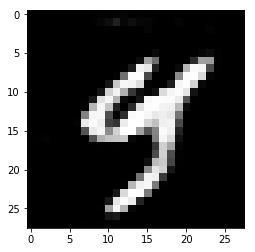

Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.6982
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 2.6614
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 2.0318
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 1.1568
Epoch 2/2... Discriminator Loss: 1.5782... Generator Loss: 0.5074
Epoch 2/2... Discriminator Loss: 1.1325... Generator Loss: 1.2064
Epoch 2/2... Discriminator Loss: 1.2940... Generator Loss: 0.9472
Epoch 2/2... Discriminator Loss: 0.7770... Generator Loss: 2.3881
Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.8112
Epoch 2/2... Discriminator Loss: 1.4856... Generator Loss: 0.9966


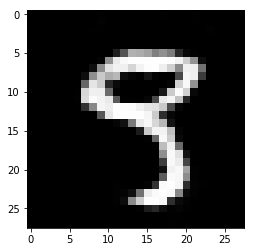

Epoch 2/2... Discriminator Loss: 1.3000... Generator Loss: 1.1624
Epoch 2/2... Discriminator Loss: 1.8184... Generator Loss: 1.7750
Epoch 2/2... Discriminator Loss: 1.6674... Generator Loss: 0.4280
Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 1.7228
Epoch 2/2... Discriminator Loss: 1.5807... Generator Loss: 0.5791
Epoch 2/2... Discriminator Loss: 0.8284... Generator Loss: 1.9879
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.7043
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.7094
Epoch 2/2... Discriminator Loss: 1.5540... Generator Loss: 0.6074
Epoch 2/2... Discriminator Loss: 1.5885... Generator Loss: 1.3325


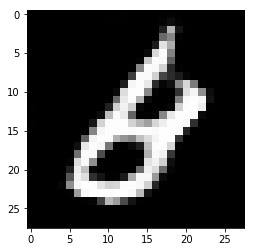

Epoch 2/2... Discriminator Loss: 1.7953... Generator Loss: 2.2679
Epoch 2/2... Discriminator Loss: 1.5633... Generator Loss: 1.1899
Epoch 2/2... Discriminator Loss: 0.9089... Generator Loss: 1.2753
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 2.6840
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 1.6853
Epoch 2/2... Discriminator Loss: 0.8602... Generator Loss: 1.9356
Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 0.6976
Epoch 2/2... Discriminator Loss: 1.8393... Generator Loss: 0.5172
Epoch 2/2... Discriminator Loss: 1.8062... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 1.5097... Generator Loss: 1.8529


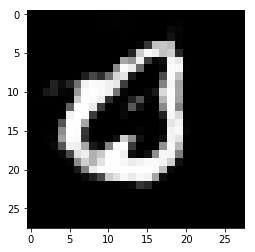

Epoch 2/2... Discriminator Loss: 1.0918... Generator Loss: 2.5031
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 0.8477
Epoch 2/2... Discriminator Loss: 1.7092... Generator Loss: 0.4809
Epoch 2/2... Discriminator Loss: 1.8140... Generator Loss: 0.4468
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 2.3460
Epoch 2/2... Discriminator Loss: 1.0219... Generator Loss: 1.4537
Epoch 2/2... Discriminator Loss: 1.8635... Generator Loss: 2.5829
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 2.2745
Epoch 2/2... Discriminator Loss: 1.3515... Generator Loss: 1.4800
Epoch 2/2... Discriminator Loss: 1.1571... Generator Loss: 1.2444


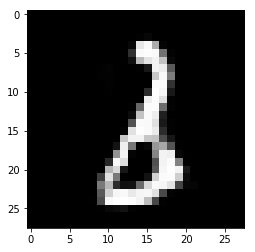

Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.8816
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.7684
Epoch 2/2... Discriminator Loss: 1.4417... Generator Loss: 1.5482
Epoch 2/2... Discriminator Loss: 1.1962... Generator Loss: 1.2417
Epoch 2/2... Discriminator Loss: 1.6063... Generator Loss: 2.3250
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 1.4020
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 1.0811
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 1.4548
Epoch 2/2... Discriminator Loss: 1.5444... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 1.7120... Generator Loss: 0.4838


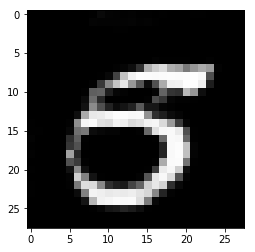

Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 2.7126
Epoch 2/2... Discriminator Loss: 1.7424... Generator Loss: 0.7330
Epoch 2/2... Discriminator Loss: 1.2109... Generator Loss: 1.1993
Epoch 2/2... Discriminator Loss: 1.0867... Generator Loss: 1.5332
Epoch 2/2... Discriminator Loss: 1.1762... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 1.6299... Generator Loss: 0.9486
Epoch 2/2... Discriminator Loss: 1.4023... Generator Loss: 2.3798
Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 1.4553
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 1.5646


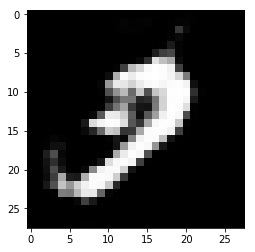

Epoch 2/2... Discriminator Loss: 1.5422... Generator Loss: 1.8690
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 0.8265
Epoch 2/2... Discriminator Loss: 1.6073... Generator Loss: 1.1170
Epoch 2/2... Discriminator Loss: 1.4486... Generator Loss: 2.3745
Epoch 2/2... Discriminator Loss: 1.2949... Generator Loss: 1.3597
Epoch 2/2... Discriminator Loss: 1.7107... Generator Loss: 1.7351
Epoch 2/2... Discriminator Loss: 1.2120... Generator Loss: 1.9353
Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 2.0659
Epoch 2/2... Discriminator Loss: 1.6277... Generator Loss: 1.2348
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 1.3974


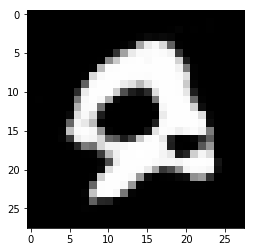

Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 1.9353
Epoch 2/2... Discriminator Loss: 1.7680... Generator Loss: 2.9152
Epoch 2/2... Discriminator Loss: 1.5710... Generator Loss: 1.7071
Epoch 2/2... Discriminator Loss: 1.8845... Generator Loss: 4.5189
Epoch 2/2... Discriminator Loss: 1.1364... Generator Loss: 1.9337
Epoch 2/2... Discriminator Loss: 1.5167... Generator Loss: 1.3992
Epoch 2/2... Discriminator Loss: 2.0809... Generator Loss: 1.6986
Epoch 2/2... Discriminator Loss: 1.6913... Generator Loss: 2.1723
Epoch 2/2... Discriminator Loss: 2.0931... Generator Loss: 0.9581
Epoch 2/2... Discriminator Loss: 1.9691... Generator Loss: 1.7839


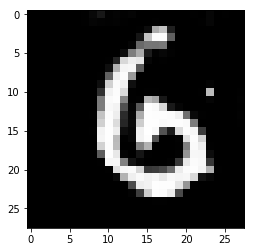

Epoch 2/2... Discriminator Loss: 2.4541... Generator Loss: 2.4772
Epoch 2/2... Discriminator Loss: 1.0825... Generator Loss: 4.2756
Epoch 2/2... Discriminator Loss: 1.5655... Generator Loss: 1.8285
Epoch 2/2... Discriminator Loss: 1.4897... Generator Loss: 1.6433
Epoch 2/2... Discriminator Loss: 2.0575... Generator Loss: 2.5459
Epoch 2/2... Discriminator Loss: 1.4231... Generator Loss: 3.2358
Epoch 2/2... Discriminator Loss: 1.5548... Generator Loss: 1.6671
Epoch 2/2... Discriminator Loss: 2.3249... Generator Loss: 2.1470
Epoch 2/2... Discriminator Loss: 0.8752... Generator Loss: 2.1674
Epoch 2/2... Discriminator Loss: 0.8957... Generator Loss: 1.5125


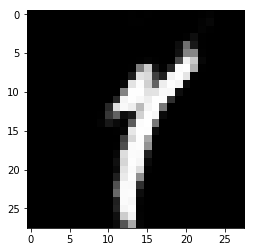

Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 3.2503
Epoch 2/2... Discriminator Loss: 0.6913... Generator Loss: 2.3587
Epoch 2/2... Discriminator Loss: 1.4343... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 1.9965... Generator Loss: 2.1561
Epoch 2/2... Discriminator Loss: 1.8049... Generator Loss: 2.7575
Epoch 2/2... Discriminator Loss: 1.5480... Generator Loss: 1.8649
Epoch 2/2... Discriminator Loss: 2.0420... Generator Loss: 1.5359
Epoch 2/2... Discriminator Loss: 2.3707... Generator Loss: 1.9201
Epoch 2/2... Discriminator Loss: 2.7958... Generator Loss: 1.2605
Epoch 2/2... Discriminator Loss: 1.7020... Generator Loss: 0.8399


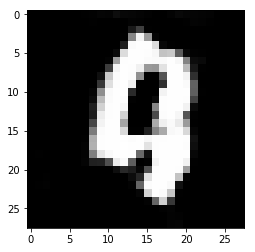

Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 1.4410
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 1.1356
Epoch 2/2... Discriminator Loss: 1.3689... Generator Loss: 1.7335
Epoch 2/2... Discriminator Loss: 1.8844... Generator Loss: 1.5991
Epoch 2/2... Discriminator Loss: 1.8108... Generator Loss: 2.0233
Epoch 2/2... Discriminator Loss: 1.9553... Generator Loss: 0.7862
Epoch 2/2... Discriminator Loss: 1.6443... Generator Loss: 3.0203
Epoch 2/2... Discriminator Loss: 2.2717... Generator Loss: 1.9371
Epoch 2/2... Discriminator Loss: 1.8545... Generator Loss: 1.2380
Epoch 2/2... Discriminator Loss: 2.0654... Generator Loss: 0.7830


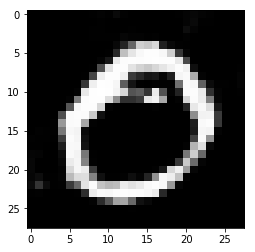

Epoch 2/2... Discriminator Loss: 1.6166... Generator Loss: 3.5686
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 2.1573
Epoch 2/2... Discriminator Loss: 1.9618... Generator Loss: 1.2381
Epoch 2/2... Discriminator Loss: 2.1362... Generator Loss: 0.8723
Epoch 2/2... Discriminator Loss: 2.0782... Generator Loss: 2.3224
Epoch 2/2... Discriminator Loss: 1.5156... Generator Loss: 2.4043
Epoch 2/2... Discriminator Loss: 1.7342... Generator Loss: 0.6341
Epoch 2/2... Discriminator Loss: 1.5350... Generator Loss: 0.7763
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.2853
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 1.7618


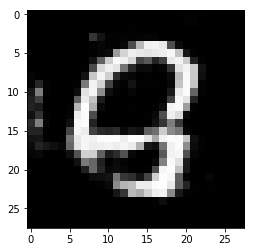

Epoch 2/2... Discriminator Loss: 1.6705... Generator Loss: 1.8835
Epoch 2/2... Discriminator Loss: 1.5107... Generator Loss: 1.4857
Epoch 2/2... Discriminator Loss: 2.7088... Generator Loss: 1.1231
Epoch 2/2... Discriminator Loss: 1.7195... Generator Loss: 1.9848
Epoch 2/2... Discriminator Loss: 2.4016... Generator Loss: 0.8416
Epoch 2/2... Discriminator Loss: 1.9485... Generator Loss: 1.7429
Epoch 2/2... Discriminator Loss: 2.3906... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 2.6635
Epoch 2/2... Discriminator Loss: 1.6608... Generator Loss: 1.0234
Epoch 2/2... Discriminator Loss: 2.1340... Generator Loss: 0.5302


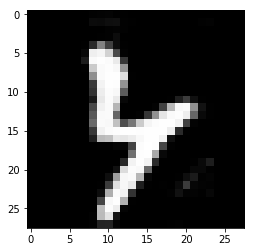

Epoch 2/2... Discriminator Loss: 1.4961... Generator Loss: 2.1631
Epoch 2/2... Discriminator Loss: 2.0552... Generator Loss: 1.0361
Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 1.6643
Epoch 2/2... Discriminator Loss: 1.1365... Generator Loss: 1.1037
Epoch 2/2... Discriminator Loss: 1.5270... Generator Loss: 2.0920
Epoch 2/2... Discriminator Loss: 3.0141... Generator Loss: 1.6534
Epoch 2/2... Discriminator Loss: 1.5361... Generator Loss: 1.6079
Epoch 2/2... Discriminator Loss: 2.5500... Generator Loss: 0.5915
Epoch 2/2... Discriminator Loss: 2.7127... Generator Loss: 2.1084
Epoch 2/2... Discriminator Loss: 1.6524... Generator Loss: 1.3775


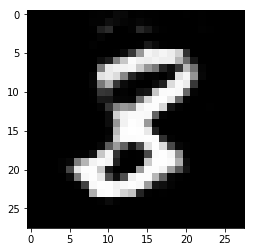

Epoch 2/2... Discriminator Loss: 2.1647... Generator Loss: 1.3700
Epoch 2/2... Discriminator Loss: 2.1398... Generator Loss: 0.7275
Epoch 2/2... Discriminator Loss: 1.9960... Generator Loss: 1.9441
Epoch 2/2... Discriminator Loss: 2.6438... Generator Loss: 1.7994
Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 2.5605
Epoch 2/2... Discriminator Loss: 1.8868... Generator Loss: 1.0843
Epoch 2/2... Discriminator Loss: 1.9083... Generator Loss: 1.4537
Epoch 2/2... Discriminator Loss: 2.3105... Generator Loss: 1.6665
Epoch 2/2... Discriminator Loss: 2.5094... Generator Loss: 1.1185
Epoch 2/2... Discriminator Loss: 2.0921... Generator Loss: 3.4395


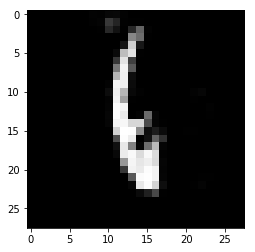

Epoch 2/2... Discriminator Loss: 1.6191... Generator Loss: 0.9918
Epoch 2/2... Discriminator Loss: 1.9455... Generator Loss: 1.6240
Epoch 2/2... Discriminator Loss: 1.9208... Generator Loss: 2.1339
Epoch 2/2... Discriminator Loss: 1.8188... Generator Loss: 1.9242
Epoch 2/2... Discriminator Loss: 1.5768... Generator Loss: 2.3649
Epoch 2/2... Discriminator Loss: 1.9791... Generator Loss: 2.5335
Epoch 2/2... Discriminator Loss: 1.6509... Generator Loss: 3.2325
Epoch 2/2... Discriminator Loss: 1.2371... Generator Loss: 3.4130
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 2.0824
Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 1.8854


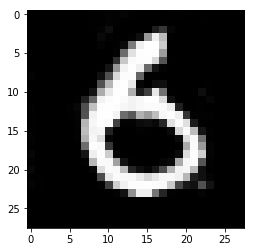

Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 1.8131
Epoch 2/2... Discriminator Loss: 1.4640... Generator Loss: 2.1380
Epoch 2/2... Discriminator Loss: 1.3542... Generator Loss: 1.4972
Epoch 2/2... Discriminator Loss: 1.6913... Generator Loss: 2.3438
Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 1.2135
Epoch 2/2... Discriminator Loss: 0.8533... Generator Loss: 1.9056
Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 1.1609
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 2.2007
Epoch 2/2... Discriminator Loss: 1.8167... Generator Loss: 1.6842
Epoch 2/2... Discriminator Loss: 1.6823... Generator Loss: 0.5341


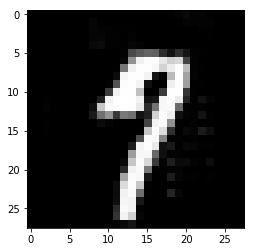

Epoch 2/2... Discriminator Loss: 0.7203... Generator Loss: 2.2457
Epoch 2/2... Discriminator Loss: 1.2944... Generator Loss: 1.8000
Epoch 2/2... Discriminator Loss: 1.3703... Generator Loss: 1.7073
Epoch 2/2... Discriminator Loss: 1.7234... Generator Loss: 1.0219
Epoch 2/2... Discriminator Loss: 1.7318... Generator Loss: 1.3434
Done, showing samples


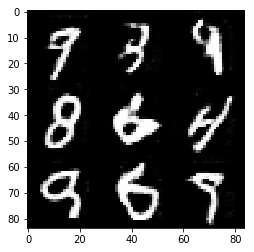

In [50]:
batch_size = 32
z_dim = 100 
learning_rate = 0.0004
beta1 = 0.6 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 3.5030
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 12.7278
Epoch 1/1... Discriminator Loss: 1.7164... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.2461
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 2.8626
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 2.2081... Generator Loss: 0.2433
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.7715
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.4076


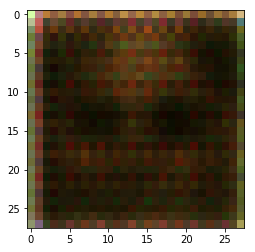

Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.3147
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.3518
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 1.8556
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 3.3863


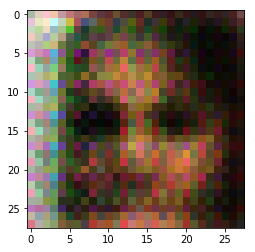

Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 1.3058
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.5804
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 2.3628
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.3873
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.8791
Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 1.7559
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 0.9779


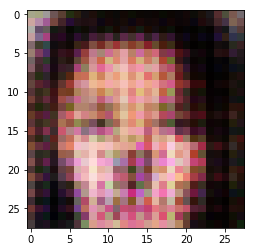

Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 2.1016
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 2.0223
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 2.9877
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.4148
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 1.6790
Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 2.4815


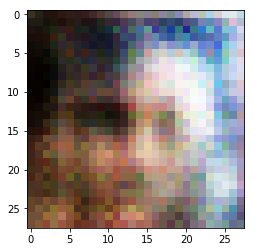

Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 1.3067
Epoch 1/1... Discriminator Loss: 0.7017... Generator Loss: 2.3633
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 1.2934
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 2.3002
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 1.9606
Epoch 1/1... Discriminator Loss: 1.6328... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.2521


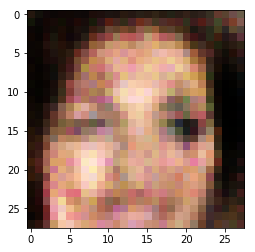

Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 3.2131
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.2914
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.0048
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.3173
Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 3.0392
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 2.1171... Generator Loss: 0.3159


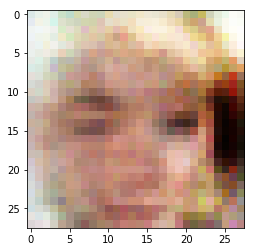

Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 2.5708
Epoch 1/1... Discriminator Loss: 0.4728... Generator Loss: 2.8510
Epoch 1/1... Discriminator Loss: 0.4336... Generator Loss: 3.2551
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 3.3620
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 2.4674
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 0.5041... Generator Loss: 2.5553
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 1.6634


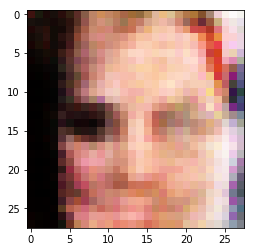

Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 3.1414
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 2.9181
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 2.4733
Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 1.4595
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.2213
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 2.1392
Epoch 1/1... Discriminator Loss: 2.2334... Generator Loss: 0.2417
Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 1.6662
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 0.9997


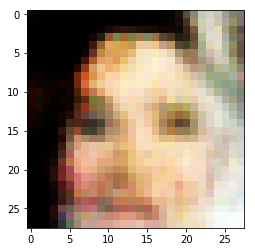

Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 2.6704
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 5.1533
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 1.9302
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.7496
Epoch 1/1... Discriminator Loss: 1.6599... Generator Loss: 0.5030
Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 2.0536
Epoch 1/1... Discriminator Loss: 1.9411... Generator Loss: 0.3517


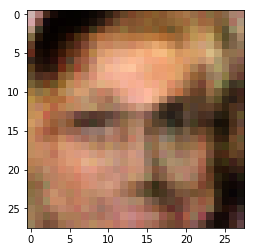

Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 2.2042
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.8461... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 3.8668
Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 1.7254
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.4277
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 2.2627... Generator Loss: 0.3099
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.0896


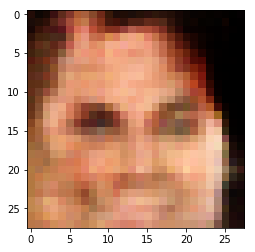

Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 1.6659
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.2121
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 1.6064
Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 2.3709
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 2.6360
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 1.9776
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.4304
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 1.7463


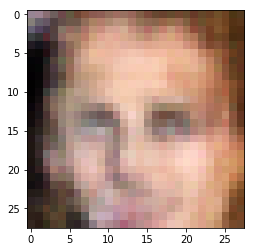

Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 1.6585
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 2.0938... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 1.7688
Epoch 1/1... Discriminator Loss: 0.7624... Generator Loss: 1.6458
Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 2.7789
Epoch 1/1... Discriminator Loss: 1.8622... Generator Loss: 0.3878
Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 2.4132
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.8904


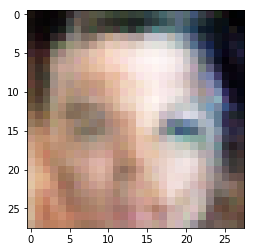

Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.6157
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 1.3374
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 2.0792
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 2.7033
Epoch 1/1... Discriminator Loss: 1.8685... Generator Loss: 0.4725
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 1.9331
Epoch 1/1... Discriminator Loss: 0.5574... Generator Loss: 2.5741
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.0465


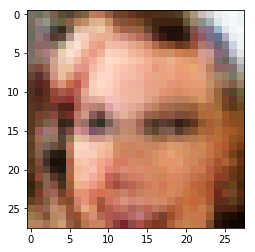

Epoch 1/1... Discriminator Loss: 1.6810... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 4.4333
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 1.7839
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 2.9405
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.9071... Generator Loss: 0.4212
Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 3.7511
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.9453


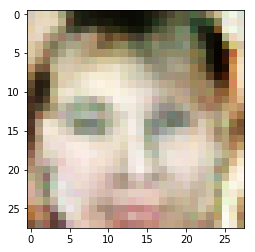

Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.4251
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 2.0015
Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 2.4337
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.3899
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 4.3484
Epoch 1/1... Discriminator Loss: 0.4418... Generator Loss: 3.3009
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.1053


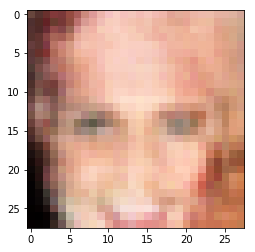

Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 0.6924... Generator Loss: 1.7893
Epoch 1/1... Discriminator Loss: 1.8127... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.1775
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 2.0712
Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 1.9762
Epoch 1/1... Discriminator Loss: 2.0177... Generator Loss: 0.4681
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6263


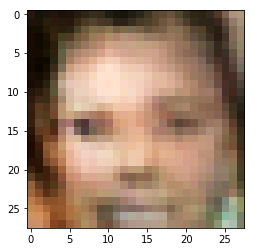

Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.5329
Epoch 1/1... Discriminator Loss: 0.4712... Generator Loss: 2.5890
Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 2.1911
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.5816... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 0.6565... Generator Loss: 1.5510
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 2.2725
Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.6607


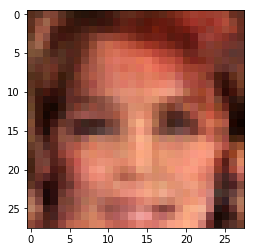

Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 1.7318
Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 1.6501
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.5169
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 1.5900
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 1.6788
Epoch 1/1... Discriminator Loss: 0.5642... Generator Loss: 1.9678


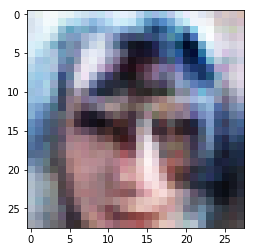

Epoch 1/1... Discriminator Loss: 0.5792... Generator Loss: 2.0307
Epoch 1/1... Discriminator Loss: 0.5902... Generator Loss: 4.3286
Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 1.9204
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.1321
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.0437
Epoch 1/1... Discriminator Loss: 1.6863... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 1.8792
Epoch 1/1... Discriminator Loss: 1.6467... Generator Loss: 0.4493


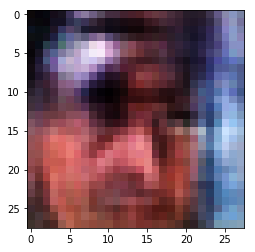

Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 2.1524
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 3.0967
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 1.5338
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.4190
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.6175
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 2.4441
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.8371


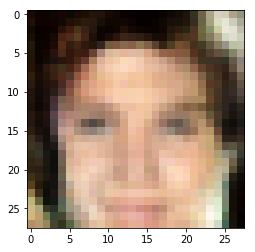

Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 1.5831
Epoch 1/1... Discriminator Loss: 0.5726... Generator Loss: 1.9546
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 2.0967
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 1.7034
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.9889


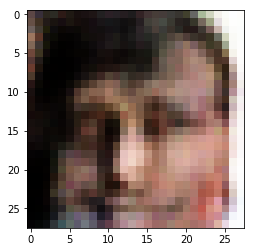

Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 2.9457
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 1.6381
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 1.5107
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.0851
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.4133


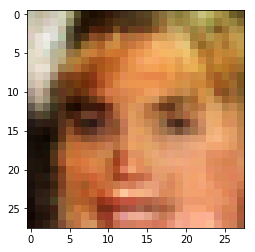

Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.2776
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 2.0395
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.5681
Epoch 1/1... Discriminator Loss: 0.7483... Generator Loss: 1.4016
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 3.4534
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.7647


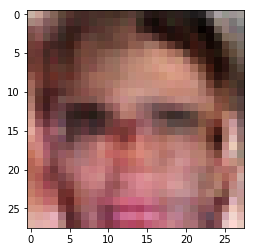

Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.3325
Epoch 1/1... Discriminator Loss: 0.6977... Generator Loss: 3.0928
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 1.8444
Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.4999
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.7823
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 2.5895


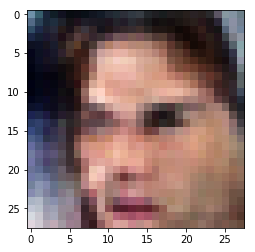

Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 2.6313
Epoch 1/1... Discriminator Loss: 0.5032... Generator Loss: 2.8752
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 2.0676
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.3225
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.9425
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 2.7284
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.4383
Epoch 1/1... Discriminator Loss: 0.4567... Generator Loss: 2.8114


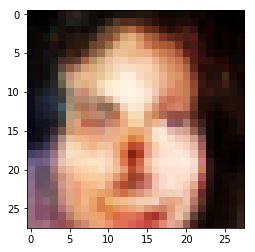

Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.4652
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.0681
Epoch 1/1... Discriminator Loss: 1.6178... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 1.3245
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.5778
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.7521


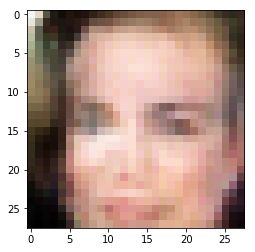

Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 2.1930
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.2525
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 1.9597
Epoch 1/1... Discriminator Loss: 0.5438... Generator Loss: 2.8988
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.8893


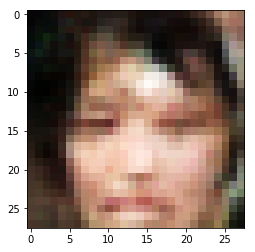

Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.5375
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.3369
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 1.1321
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 1.8362
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 4.1731
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.6176


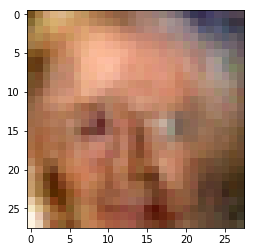

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 2.0175
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 2.3888
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.2869
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 1.9579
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 1.7958


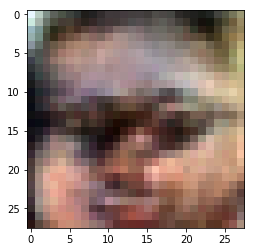

Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 2.3459
Epoch 1/1... Discriminator Loss: 2.8777... Generator Loss: 4.6237
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.5438
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 1.6124
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.5590
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 1.6179
Epoch 1/1... Discriminator Loss: 1.8010... Generator Loss: 0.3828


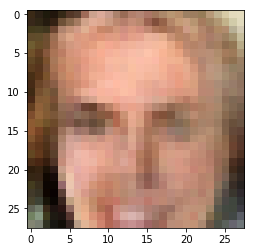

Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.8687
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 1.9932
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.3684
Epoch 1/1... Discriminator Loss: 1.6863... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 1.8823
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 2.5867
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.5398
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.8235
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 1.2619


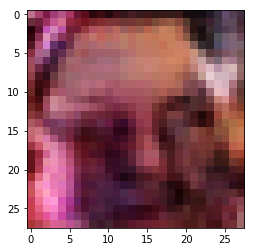

Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.5532
Epoch 1/1... Discriminator Loss: 2.1546... Generator Loss: 0.2993
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.4106
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 1.4570
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.7184
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 1.6485
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 2.7526
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 2.5673


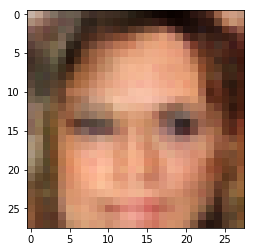

Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 2.0239
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 1.5610
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 1.9146
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 3.1205
Epoch 1/1... Discriminator Loss: 1.6514... Generator Loss: 3.1704
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 2.6730
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.5298


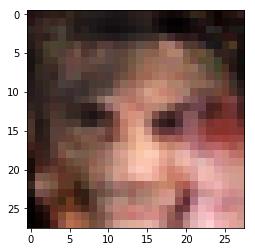

Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 1.4932
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 1.6699
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.1524
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.2980
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8345


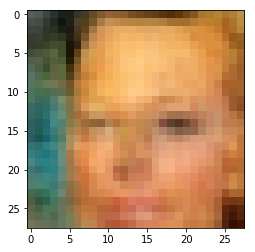

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 3.0201... Generator Loss: 0.1555
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.4646


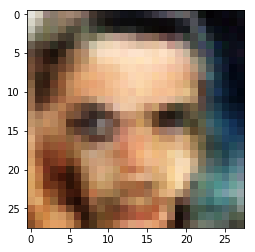

Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 1.2034
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.6746... Generator Loss: 0.4492
Epoch 1/1... Discriminator Loss: 1.6158... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 1.2668
Epoch 1/1... Discriminator Loss: 1.8272... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 1.7613
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 1.9102


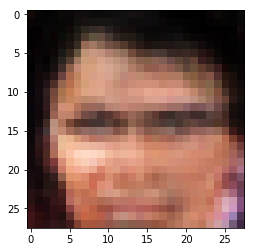

Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 1.7964
Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 2.0800
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 1.4644
Epoch 1/1... Discriminator Loss: 1.6260... Generator Loss: 2.0037
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 2.6968
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 2.0679
Epoch 1/1... Discriminator Loss: 1.9619... Generator Loss: 2.1742
Epoch 1/1... Discriminator Loss: 1.8540... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 1.8486... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 1.7055... Generator Loss: 0.6810


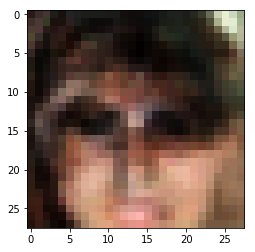

Epoch 1/1... Discriminator Loss: 1.9049... Generator Loss: 2.2282
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 2.0624
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 2.0463... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 1.8710... Generator Loss: 1.7935
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 1.1542


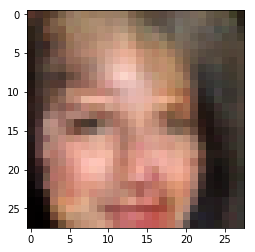

Epoch 1/1... Discriminator Loss: 2.0625... Generator Loss: 3.3177
Epoch 1/1... Discriminator Loss: 1.6967... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 1.6863... Generator Loss: 1.2428
Epoch 1/1... Discriminator Loss: 1.7865... Generator Loss: 1.6975
Epoch 1/1... Discriminator Loss: 1.8652... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.8055... Generator Loss: 1.9717
Epoch 1/1... Discriminator Loss: 3.7239... Generator Loss: 3.4334
Epoch 1/1... Discriminator Loss: 1.7594... Generator Loss: 2.3990
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 2.2287


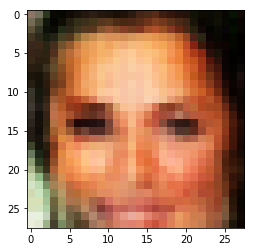

Epoch 1/1... Discriminator Loss: 2.0336... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 1.4690
Epoch 1/1... Discriminator Loss: 1.6613... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 3.2693... Generator Loss: 2.9887
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 1.6389
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 1.3347
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.9539... Generator Loss: 3.7823
Epoch 1/1... Discriminator Loss: 2.0374... Generator Loss: 1.6044
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 2.4353


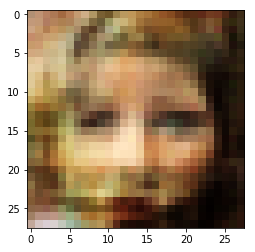

Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 2.0347... Generator Loss: 1.6029
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.3722
Epoch 1/1... Discriminator Loss: 1.6904... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 3.0948... Generator Loss: 2.0325
Epoch 1/1... Discriminator Loss: 1.9971... Generator Loss: 2.2555
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 2.0257
Epoch 1/1... Discriminator Loss: 1.6602... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 1.4615


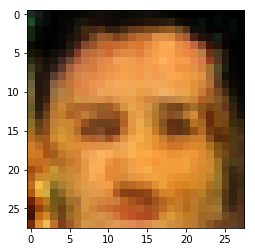

Epoch 1/1... Discriminator Loss: 1.6281... Generator Loss: 1.4356
Epoch 1/1... Discriminator Loss: 2.5872... Generator Loss: 2.7978
Epoch 1/1... Discriminator Loss: 2.2659... Generator Loss: 1.6439
Epoch 1/1... Discriminator Loss: 3.0295... Generator Loss: 3.6322
Epoch 1/1... Discriminator Loss: 2.1662... Generator Loss: 0.2339
Epoch 1/1... Discriminator Loss: 3.3345... Generator Loss: 2.3442
Epoch 1/1... Discriminator Loss: 1.7871... Generator Loss: 1.4378
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 2.5691
Epoch 1/1... Discriminator Loss: 1.6926... Generator Loss: 1.9637
Epoch 1/1... Discriminator Loss: 1.8668... Generator Loss: 2.7420


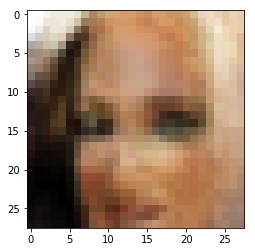

Epoch 1/1... Discriminator Loss: 2.1513... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 2.0532... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.3135
Epoch 1/1... Discriminator Loss: 2.0864... Generator Loss: 0.3535
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 1.1953
Epoch 1/1... Discriminator Loss: 1.5614... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 1.8789
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.6985... Generator Loss: 1.8451
Epoch 1/1... Discriminator Loss: 2.0254... Generator Loss: 1.5209


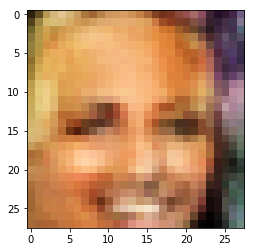

Epoch 1/1... Discriminator Loss: 2.0181... Generator Loss: 1.2610
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 2.6881... Generator Loss: 1.4185
Epoch 1/1... Discriminator Loss: 1.6607... Generator Loss: 1.5657
Epoch 1/1... Discriminator Loss: 2.0466... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.9750... Generator Loss: 1.6807
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 2.1575... Generator Loss: 1.7187
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 2.6542... Generator Loss: 2.1292


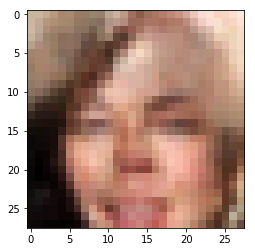

Epoch 1/1... Discriminator Loss: 1.7695... Generator Loss: 1.9731
Epoch 1/1... Discriminator Loss: 1.8048... Generator Loss: 2.0274
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 2.0658
Epoch 1/1... Discriminator Loss: 3.3368... Generator Loss: 3.7073
Epoch 1/1... Discriminator Loss: 1.6427... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 2.4928
Epoch 1/1... Discriminator Loss: 2.0446... Generator Loss: 1.3016
Epoch 1/1... Discriminator Loss: 2.0710... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 2.5955... Generator Loss: 1.7260


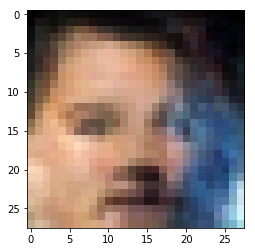

Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 1.4601
Epoch 1/1... Discriminator Loss: 2.1351... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.7218... Generator Loss: 1.3346
Epoch 1/1... Discriminator Loss: 2.0897... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.7050... Generator Loss: 1.5701
Epoch 1/1... Discriminator Loss: 2.4263... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.8780... Generator Loss: 1.2332
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.7880... Generator Loss: 2.1261


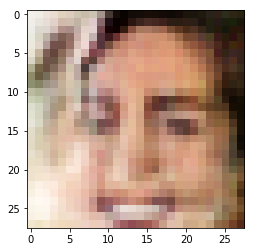

Epoch 1/1... Discriminator Loss: 1.7243... Generator Loss: 1.5478
Epoch 1/1... Discriminator Loss: 2.2902... Generator Loss: 1.9104
Epoch 1/1... Discriminator Loss: 2.6924... Generator Loss: 2.4854
Epoch 1/1... Discriminator Loss: 2.3247... Generator Loss: 0.2674
Epoch 1/1... Discriminator Loss: 2.0841... Generator Loss: 1.8073
Epoch 1/1... Discriminator Loss: 2.3318... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 2.9013... Generator Loss: 2.2056
Epoch 1/1... Discriminator Loss: 1.6080... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.7311... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 1.3862


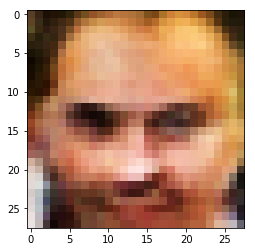

Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 2.1708... Generator Loss: 1.9950
Epoch 1/1... Discriminator Loss: 2.0816... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 1.7779
Epoch 1/1... Discriminator Loss: 1.6278... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.8586... Generator Loss: 1.7166
Epoch 1/1... Discriminator Loss: 3.1080... Generator Loss: 1.9381
Epoch 1/1... Discriminator Loss: 2.0978... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.7813... Generator Loss: 1.6788
Epoch 1/1... Discriminator Loss: 1.6861... Generator Loss: 1.2206


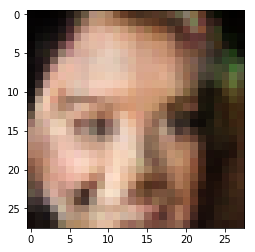

Epoch 1/1... Discriminator Loss: 2.5999... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.7184... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.8596... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 2.1688... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 2.9099... Generator Loss: 1.9490
Epoch 1/1... Discriminator Loss: 2.0569... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.8283... Generator Loss: 1.8471
Epoch 1/1... Discriminator Loss: 1.6661... Generator Loss: 1.8557
Epoch 1/1... Discriminator Loss: 2.0420... Generator Loss: 0.7310


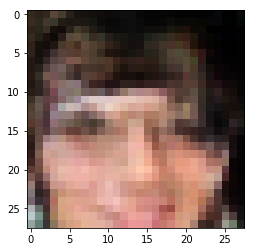

Epoch 1/1... Discriminator Loss: 2.6414... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 2.2639... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.7450... Generator Loss: 2.5338
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 1.7227
Epoch 1/1... Discriminator Loss: 1.7134... Generator Loss: 2.3229
Epoch 1/1... Discriminator Loss: 2.3868... Generator Loss: 1.9347
Epoch 1/1... Discriminator Loss: 1.8215... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.8323... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 3.2206... Generator Loss: 2.5960
Epoch 1/1... Discriminator Loss: 3.4540... Generator Loss: 1.1620


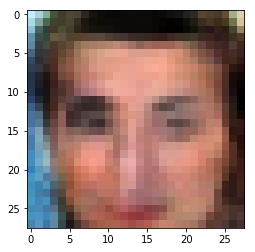

Epoch 1/1... Discriminator Loss: 3.2977... Generator Loss: 1.4993
Epoch 1/1... Discriminator Loss: 1.8381... Generator Loss: 1.4136
Epoch 1/1... Discriminator Loss: 3.7886... Generator Loss: 2.8328
Epoch 1/1... Discriminator Loss: 2.8766... Generator Loss: 3.2528
Epoch 1/1... Discriminator Loss: 2.0711... Generator Loss: 1.8419
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.9600
Epoch 1/1... Discriminator Loss: 1.8493... Generator Loss: 1.7500
Epoch 1/1... Discriminator Loss: 2.5267... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 1.9365... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.9722... Generator Loss: 1.2839


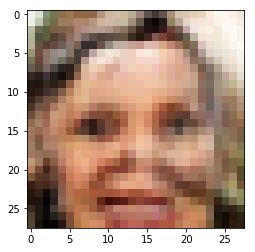

Epoch 1/1... Discriminator Loss: 3.0673... Generator Loss: 3.5005
Epoch 1/1... Discriminator Loss: 1.5833... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 2.3883... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 2.3922... Generator Loss: 1.4396
Epoch 1/1... Discriminator Loss: 2.7319... Generator Loss: 1.7313
Epoch 1/1... Discriminator Loss: 2.5498... Generator Loss: 2.0028
Epoch 1/1... Discriminator Loss: 2.4260... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 1.9327... Generator Loss: 1.7719
Epoch 1/1... Discriminator Loss: 2.4240... Generator Loss: 0.3211
Epoch 1/1... Discriminator Loss: 1.9193... Generator Loss: 0.6469


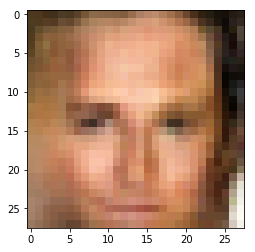

Epoch 1/1... Discriminator Loss: 2.7262... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 3.1614... Generator Loss: 1.6754
Epoch 1/1... Discriminator Loss: 2.1814... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 2.4495... Generator Loss: 1.2685
Epoch 1/1... Discriminator Loss: 3.0658... Generator Loss: 1.8369
Epoch 1/1... Discriminator Loss: 2.3595... Generator Loss: 1.3111
Epoch 1/1... Discriminator Loss: 2.7257... Generator Loss: 1.6080
Epoch 1/1... Discriminator Loss: 2.5261... Generator Loss: 3.6165
Epoch 1/1... Discriminator Loss: 3.1372... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 2.5169... Generator Loss: 1.5839


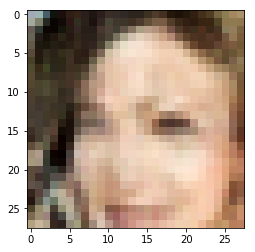

Epoch 1/1... Discriminator Loss: 2.7419... Generator Loss: 2.1722
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 1.6706
Epoch 1/1... Discriminator Loss: 2.3770... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 2.9362... Generator Loss: 0.2490
Epoch 1/1... Discriminator Loss: 2.8161... Generator Loss: 0.2497
Epoch 1/1... Discriminator Loss: 1.6026... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 2.8639... Generator Loss: 0.2060
Epoch 1/1... Discriminator Loss: 2.4128... Generator Loss: 1.5226
Epoch 1/1... Discriminator Loss: 1.9406... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.7503... Generator Loss: 1.0560


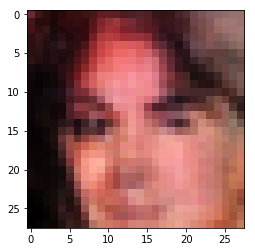

Epoch 1/1... Discriminator Loss: 1.9498... Generator Loss: 1.7933
Epoch 1/1... Discriminator Loss: 3.1135... Generator Loss: 2.6590
Epoch 1/1... Discriminator Loss: 2.0638... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 2.6927... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 2.3008... Generator Loss: 1.7184
Epoch 1/1... Discriminator Loss: 3.2579... Generator Loss: 1.5675
Epoch 1/1... Discriminator Loss: 1.7569... Generator Loss: 1.5412
Epoch 1/1... Discriminator Loss: 1.9624... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.9350... Generator Loss: 1.5772
Epoch 1/1... Discriminator Loss: 3.0457... Generator Loss: 0.6037


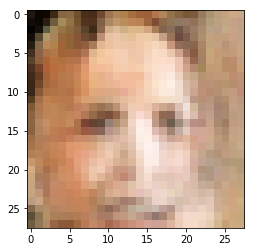

Epoch 1/1... Discriminator Loss: 1.8875... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 1.9243... Generator Loss: 1.4029
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 2.0246
Epoch 1/1... Discriminator Loss: 2.1430... Generator Loss: 1.8050
Epoch 1/1... Discriminator Loss: 2.6216... Generator Loss: 3.2169
Epoch 1/1... Discriminator Loss: 2.6634... Generator Loss: 1.8103
Epoch 1/1... Discriminator Loss: 3.1455... Generator Loss: 1.2115
Epoch 1/1... Discriminator Loss: 3.4468... Generator Loss: 2.5797
Epoch 1/1... Discriminator Loss: 3.2777... Generator Loss: 0.1286
Epoch 1/1... Discriminator Loss: 1.8814... Generator Loss: 2.2769


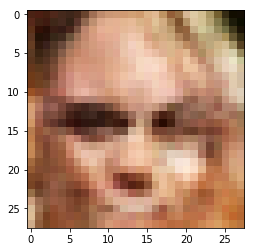

Epoch 1/1... Discriminator Loss: 2.2202... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 2.6272... Generator Loss: 2.0413
Epoch 1/1... Discriminator Loss: 3.3866... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 3.8728... Generator Loss: 2.9789
Epoch 1/1... Discriminator Loss: 2.0933... Generator Loss: 0.3494
Epoch 1/1... Discriminator Loss: 2.0422... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 2.3324... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 2.6210... Generator Loss: 1.9287
Epoch 1/1... Discriminator Loss: 2.8320... Generator Loss: 2.4239
Epoch 1/1... Discriminator Loss: 2.8922... Generator Loss: 1.2107


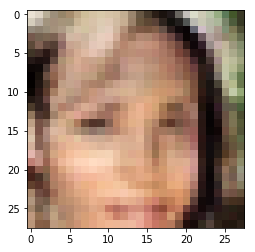

Epoch 1/1... Discriminator Loss: 2.9284... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 3.0255... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 2.4058... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.9535... Generator Loss: 2.4294
Epoch 1/1... Discriminator Loss: 2.0662... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 2.4473... Generator Loss: 2.4148
Epoch 1/1... Discriminator Loss: 2.8795... Generator Loss: 1.4231
Epoch 1/1... Discriminator Loss: 2.7993... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 3.3545... Generator Loss: 2.9087
Epoch 1/1... Discriminator Loss: 2.7091... Generator Loss: 1.9944


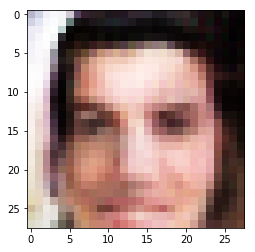

Epoch 1/1... Discriminator Loss: 3.7943... Generator Loss: 1.2582
Epoch 1/1... Discriminator Loss: 2.1710... Generator Loss: 1.8028
Epoch 1/1... Discriminator Loss: 2.6328... Generator Loss: 2.0759
Epoch 1/1... Discriminator Loss: 2.0949... Generator Loss: 2.4066
Epoch 1/1... Discriminator Loss: 2.1950... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 2.7793... Generator Loss: 1.9451
Epoch 1/1... Discriminator Loss: 1.7535... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 2.1719... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 2.9046... Generator Loss: 1.7373
Epoch 1/1... Discriminator Loss: 3.4844... Generator Loss: 2.3233


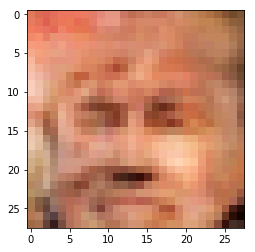

Epoch 1/1... Discriminator Loss: 2.9059... Generator Loss: 1.8892
Epoch 1/1... Discriminator Loss: 2.7617... Generator Loss: 1.6026
Epoch 1/1... Discriminator Loss: 2.3358... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 2.2531... Generator Loss: 1.8049
Epoch 1/1... Discriminator Loss: 3.2412... Generator Loss: 2.8090
Epoch 1/1... Discriminator Loss: 3.5160... Generator Loss: 1.2092
Epoch 1/1... Discriminator Loss: 3.6670... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 3.0631... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 3.0849... Generator Loss: 1.8500
Epoch 1/1... Discriminator Loss: 3.3099... Generator Loss: 0.7840


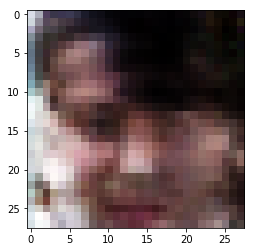

Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 1.6977
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 2.0422... Generator Loss: 0.3943
Epoch 1/1... Discriminator Loss: 1.9408... Generator Loss: 1.6546
Epoch 1/1... Discriminator Loss: 1.7890... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 2.5236... Generator Loss: 1.4769
Epoch 1/1... Discriminator Loss: 3.4377... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 3.5184... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 2.0972... Generator Loss: 1.2359
Epoch 1/1... Discriminator Loss: 2.1693... Generator Loss: 1.1110


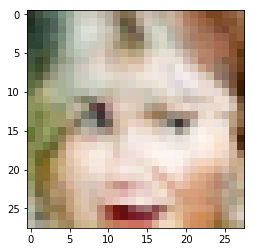

Epoch 1/1... Discriminator Loss: 2.7559... Generator Loss: 1.7611
Epoch 1/1... Discriminator Loss: 3.4188... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 3.4104... Generator Loss: 1.6163
Epoch 1/1... Discriminator Loss: 3.1309... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 2.3463... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 2.0272... Generator Loss: 3.3737
Epoch 1/1... Discriminator Loss: 2.3735... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 2.6652... Generator Loss: 2.3055
Epoch 1/1... Discriminator Loss: 1.8358... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 2.8140... Generator Loss: 1.2582


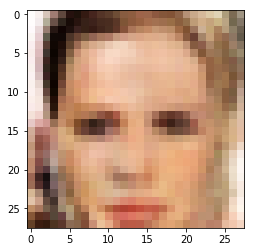

Epoch 1/1... Discriminator Loss: 4.1971... Generator Loss: 3.0034
Epoch 1/1... Discriminator Loss: 3.1295... Generator Loss: 1.9044
Epoch 1/1... Discriminator Loss: 2.5992... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 3.2402... Generator Loss: 2.0695
Epoch 1/1... Discriminator Loss: 2.4826... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 2.3142... Generator Loss: 2.4402
Epoch 1/1... Discriminator Loss: 2.6781... Generator Loss: 2.2898
Epoch 1/1... Discriminator Loss: 3.7979... Generator Loss: 1.3877
Epoch 1/1... Discriminator Loss: 2.9740... Generator Loss: 2.1641
Epoch 1/1... Discriminator Loss: 2.1387... Generator Loss: 1.4112


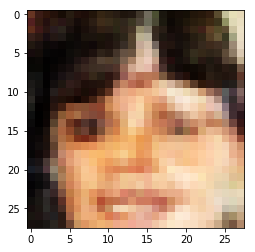

Epoch 1/1... Discriminator Loss: 2.2158... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 2.6766... Generator Loss: 0.4394
Epoch 1/1... Discriminator Loss: 3.2110... Generator Loss: 2.0617
Done, showing samples


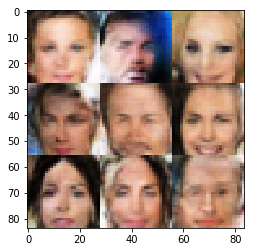

In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.6

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.